# Predicting Abalone Ages

In this notebook, we will be conducting a basic analysis of the Abalone dataset, and create a machine learning model to predict an abalone's age based on its physical characteristics. Let's begin by loading in our data and taking a look at it:

In [1]:
# Load in libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load in data
train = pd.read_csv("/kaggle/input/playground-series-s4e4/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s4e4/test.csv")

# Rename columns in dataset
new_names = {
    'Sex':'sex',
    'Length':'length',
    'Diameter':'diameter',
    'Height':'height',
    'Whole weight':'whole_weight',
    'Whole weight.1':'shucked_weight',
    'Whole weight.2':'viscera_weight',
    'Shell weight':'shell_weight',
    'Rings':'rings'
}

train.rename(columns = new_names, inplace = True)
test.rename(columns = new_names, inplace = True)

# Aggregate and inspect total data
td = pd.concat([train, test], ignore_index = True, sort = False)
td.rename(columns = new_names, inplace = True)
print(td.head())
print(td.info())

   id sex  length  diameter  height  whole_weight  shucked_weight  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   viscera_weight  shell_weight  rings  
0          0.1465        0.2400   11.0  
1          0.2765        0.3200   11.0  
2          0.0030        0.0050    6.0  
3          0.2055        0.2500   10.0  
4          0.1600        0.1975    9.0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151026 entries, 0 to 151025
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              151026 non-null  int64  
 1   sex             151026 non-null  object 
 2   length          151026 non-null  float6

Since there are no missing values, we can jump directly into the exploratory analysis phase.

# Exploratory Data Analysis and Feature Engineering

## Sex

To check if the `sex` of an abalone has any effect on its age, let's plot boxplots for both sexes:

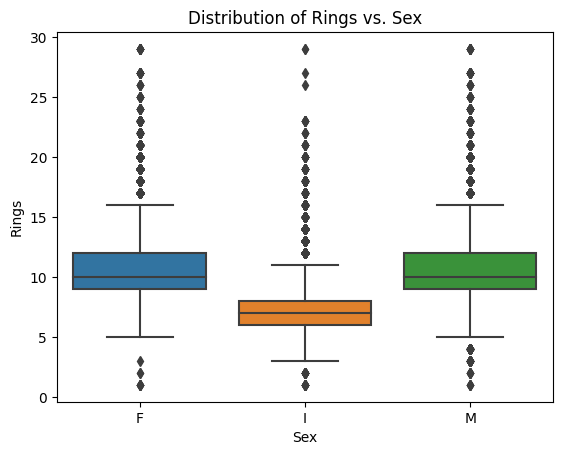

In [2]:
# Plot boxplot of rings for each sex
sns.boxplot(td, x = 'sex', y = 'rings')
plt.title('Distribution of Rings vs. Sex')
plt.ylabel('Rings')
plt.xlabel('Sex')
plt.show()

In [3]:
# Import libraries for ANOVA
import statsmodels.api as sm
from statsmodels.formula.api import ols   # Ordinary Least Squares for ANOVA

# Run ANOVA test on sex
model = ols('rings ~ C(sex)', data=td).fit()
    
# Perform ANOVA
anova_results = sm.stats.anova_lm(model, typ=2)
print("ANOVA results for rings vs. sex:")
print(anova_results)

ANOVA results for rings vs. sex:
                 sum_sq       df             F  PR(>F)
C(sex)    246334.205726      2.0  16711.859837     0.0
Residual  667814.212969  90612.0           NaN     NaN


Since one of the categories of `sex` is 'infant,' I decided to run an ANOVA to make sure it was statistically significant. We had an F-statistic of 16,711.86 and a p-value of 0, so it's overwhelmingly significant for predicting the number of rings on an abalone. Now, we can move onto the rest of the features, which are all continuous. 

## Continuous Features - Linear Relationships

Before looking at the continuous features overall, let's engineer a few features. Animals occasionally can have natural biological ratios, so let's create columns for the ratio of each type of weight to the total weight of the abalone. Then, to get an overall look at the continuous features, let's graph a heatmap of the DataFrame's correlation matrix. We'll begin by looking for any linear relationships, so we'll use Pearson's correlation coefficient:

   id sex  length  diameter  height  whole_weight  shucked_weight  \
0   0   F   0.550     0.430   0.150        0.7715          0.3285   
1   1   F   0.630     0.490   0.145        1.1300          0.4580   
2   2   I   0.160     0.110   0.025        0.0210          0.0055   
3   3   M   0.595     0.475   0.150        0.9145          0.3755   
4   4   I   0.555     0.425   0.130        0.7820          0.3695   

   viscera_weight  shell_weight  rings  shucked_weight_ratio  \
0          0.1465        0.2400   11.0              0.425794   
1          0.2765        0.3200   11.0              0.405310   
2          0.0030        0.0050    6.0              0.261905   
3          0.2055        0.2500   10.0              0.410607   
4          0.1600        0.1975    9.0              0.472506   

   viscera_weight_ratio  shell_weight_ratio  
0              0.189890            0.311082  
1              0.244690            0.283186  
2              0.142857            0.238095  
3              0

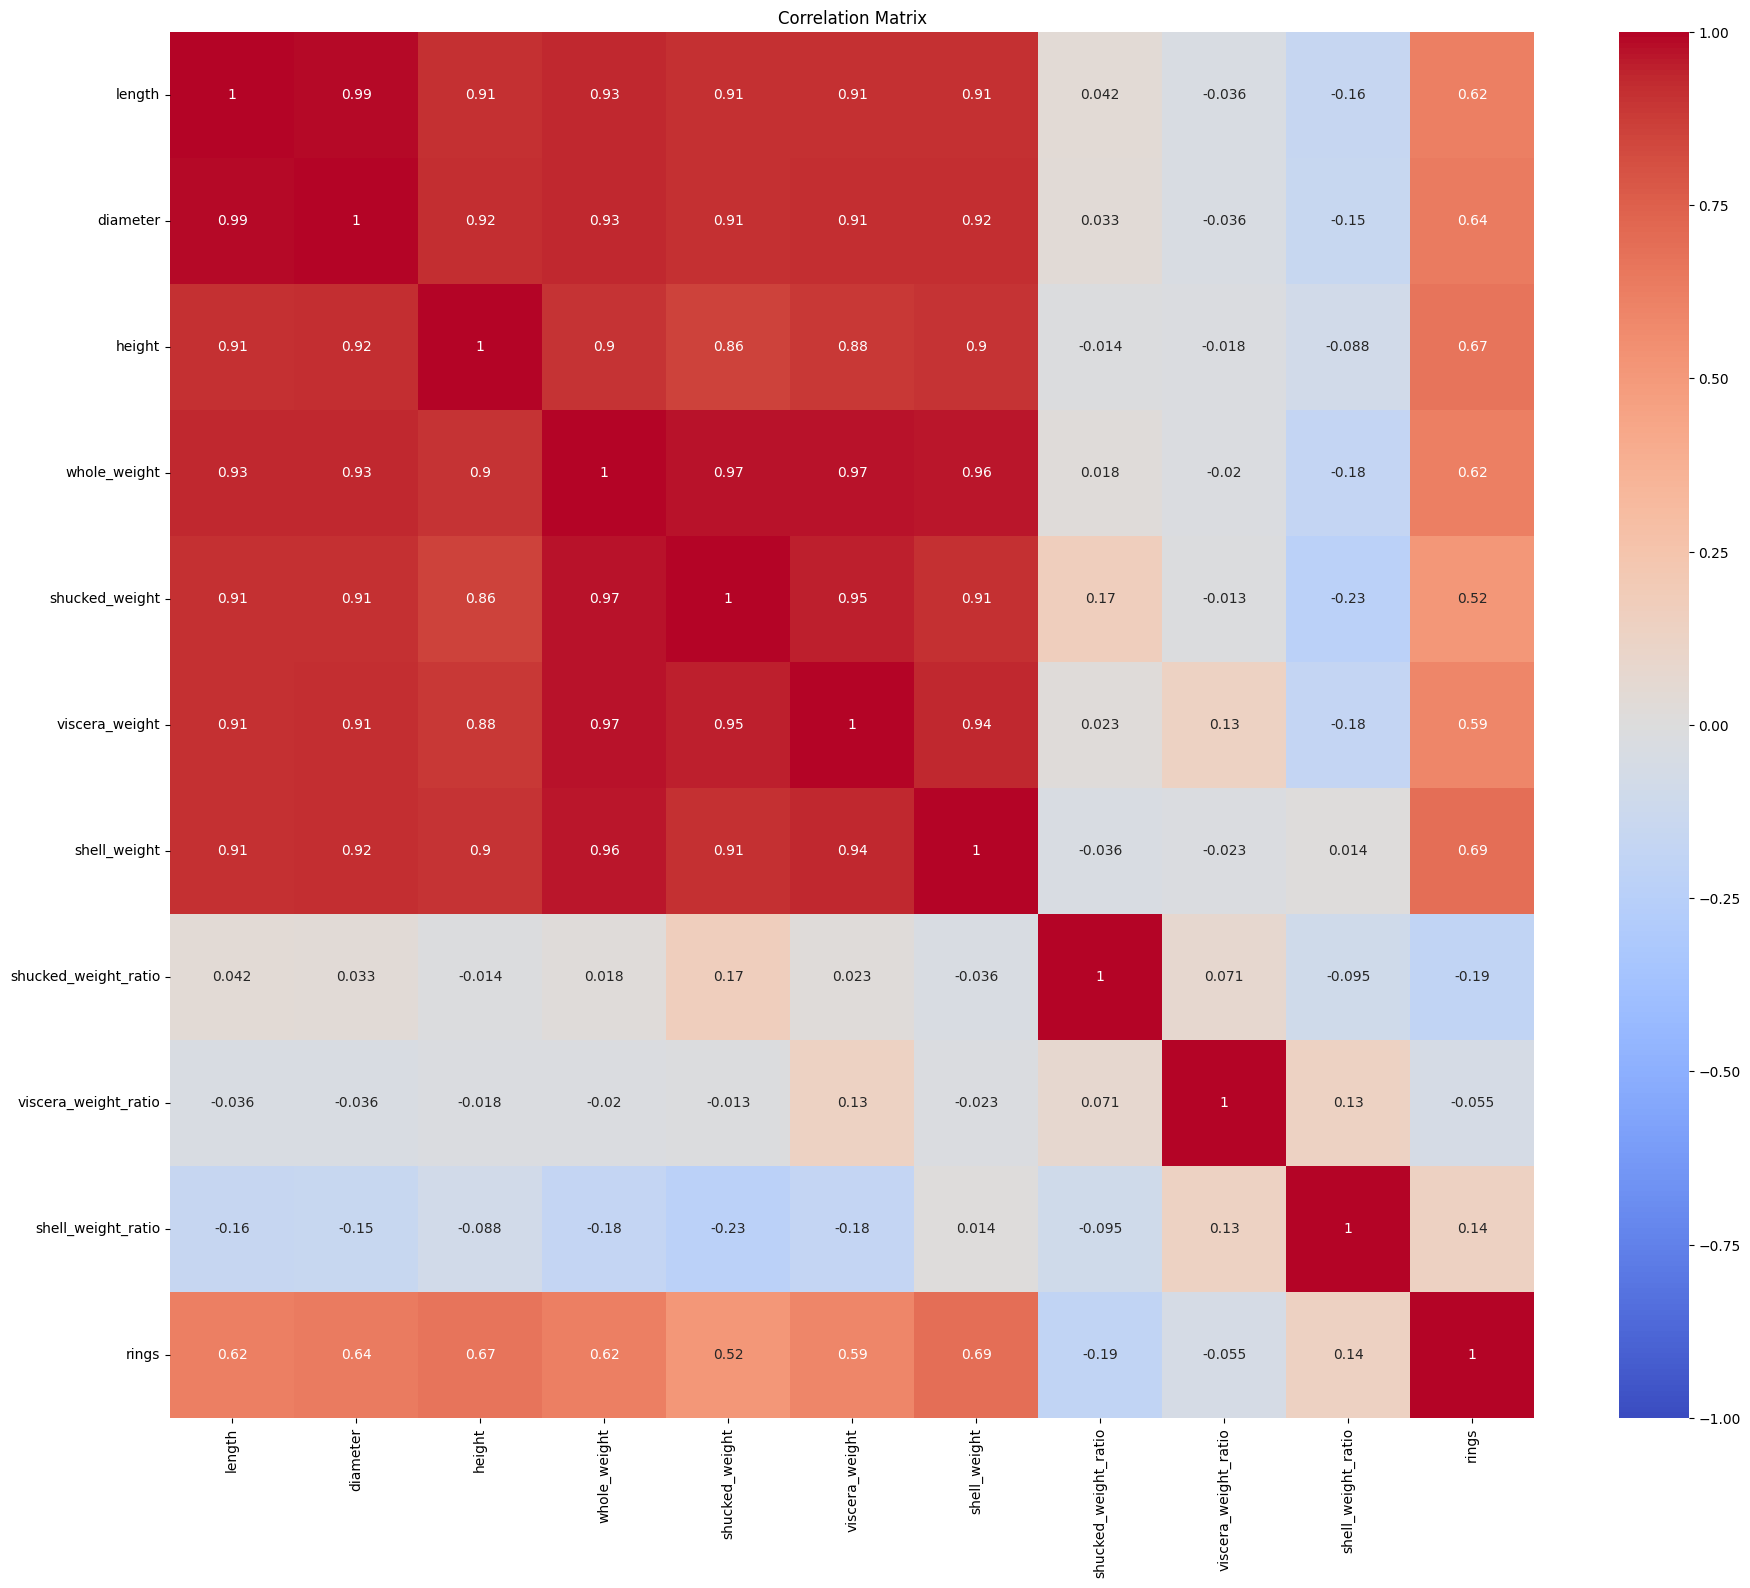

In [4]:
# Add ratio features
weights = ['shucked_weight', 'viscera_weight', 'shell_weight']

# Add new features to all three DataFrames
for weight in weights:
    col_name = weight + '_ratio'
    td[col_name] = td[weight] / td['whole_weight']
    train[col_name] = train[weight] / train['whole_weight']
    test[col_name] = test[weight] / test['whole_weight']
print(td.head(5))   # Check new features

# Calculating Pearson correlation
continuous = ['length', 'diameter', 'height', 'whole_weight', 'shucked_weight', 'viscera_weight', 'shell_weight', 'shucked_weight_ratio', 'viscera_weight_ratio', 'shell_weight_ratio', 'rings']
corr_matrix = td[continuous].corr()

# Increase figure size to make the heatmap more readable
plt.figure(figsize=(22, 18))

# Plotting the heatmap
sns.heatmap(corr_matrix, vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

From the above correlation matrix, all of the continuous columns have a positive correlation with `rings`, with the strongest correlations coming from the `shell_weight` and `height` features. Let's scatterplots of each feature vs. `sex`, and include a regression line with each one:

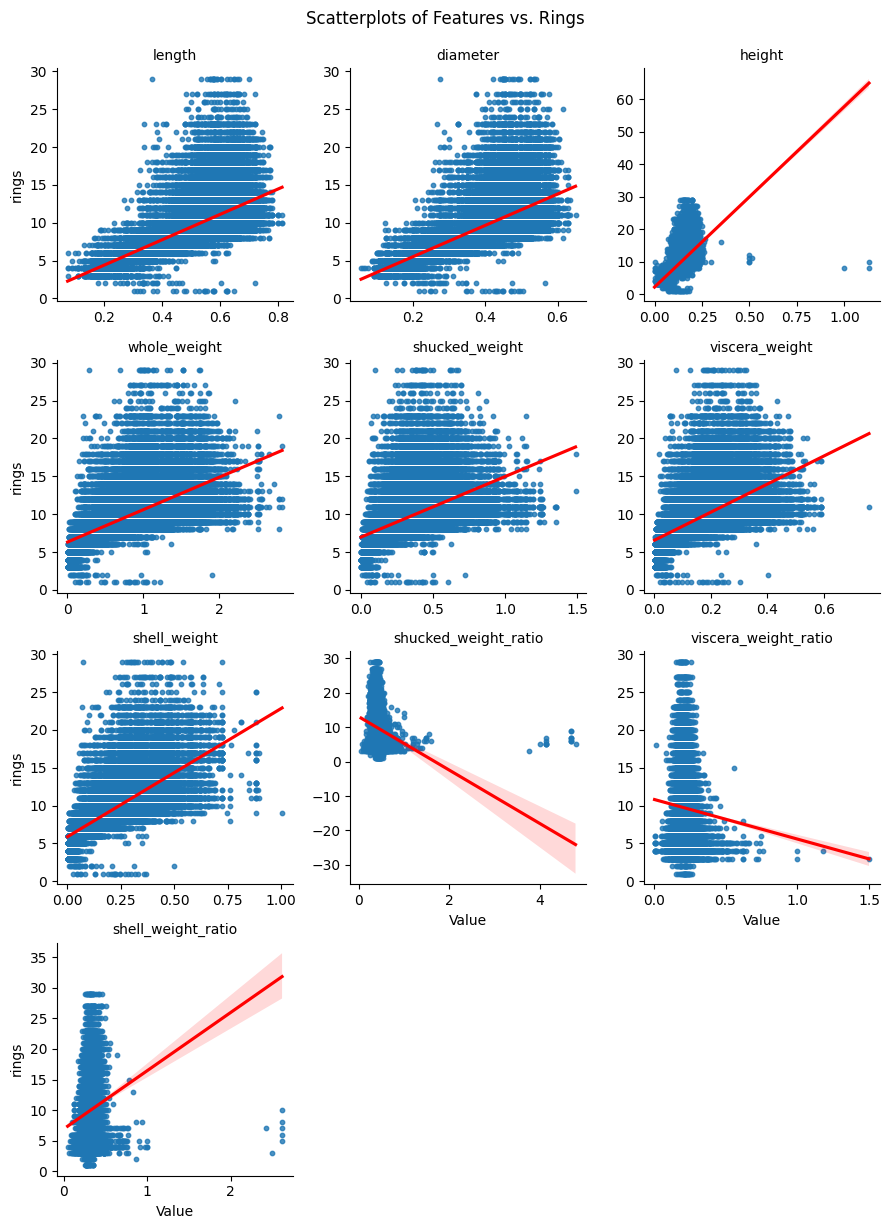

In [5]:
# Plot scatterplots of all continuous features vs. sex
td_melted = td.melt(id_vars=['rings'], value_vars = continuous, var_name = 'Feature', value_name = 'Value')
g = sns.FacetGrid(td_melted, col="Feature", col_wrap=3, height=3, sharex=False, sharey=False)
g = g.map(sns.regplot, 'Value', 'rings', scatter_kws={"s": 10}, line_kws={"color": "red"})
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Scatterplots of Features vs. Rings', y=1.02)
plt.show()

On first glance, it seems like most of our continuous features may have a non-linear relationship with `rings`. To explore this, let's begin our data engineering phase and start looking at ways we can transform our data for the best possible features.

## Feature Analysis on a Logarithmic Scale

Looking at the above graphs, it's possible that the relationship may be more linear on a logarithmic scale. Let's create a separate DataFrame with all of the continuous features on a logarithmic scale, and graph our scatterplots again:

/opt/conda/lib/python3.10/site-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


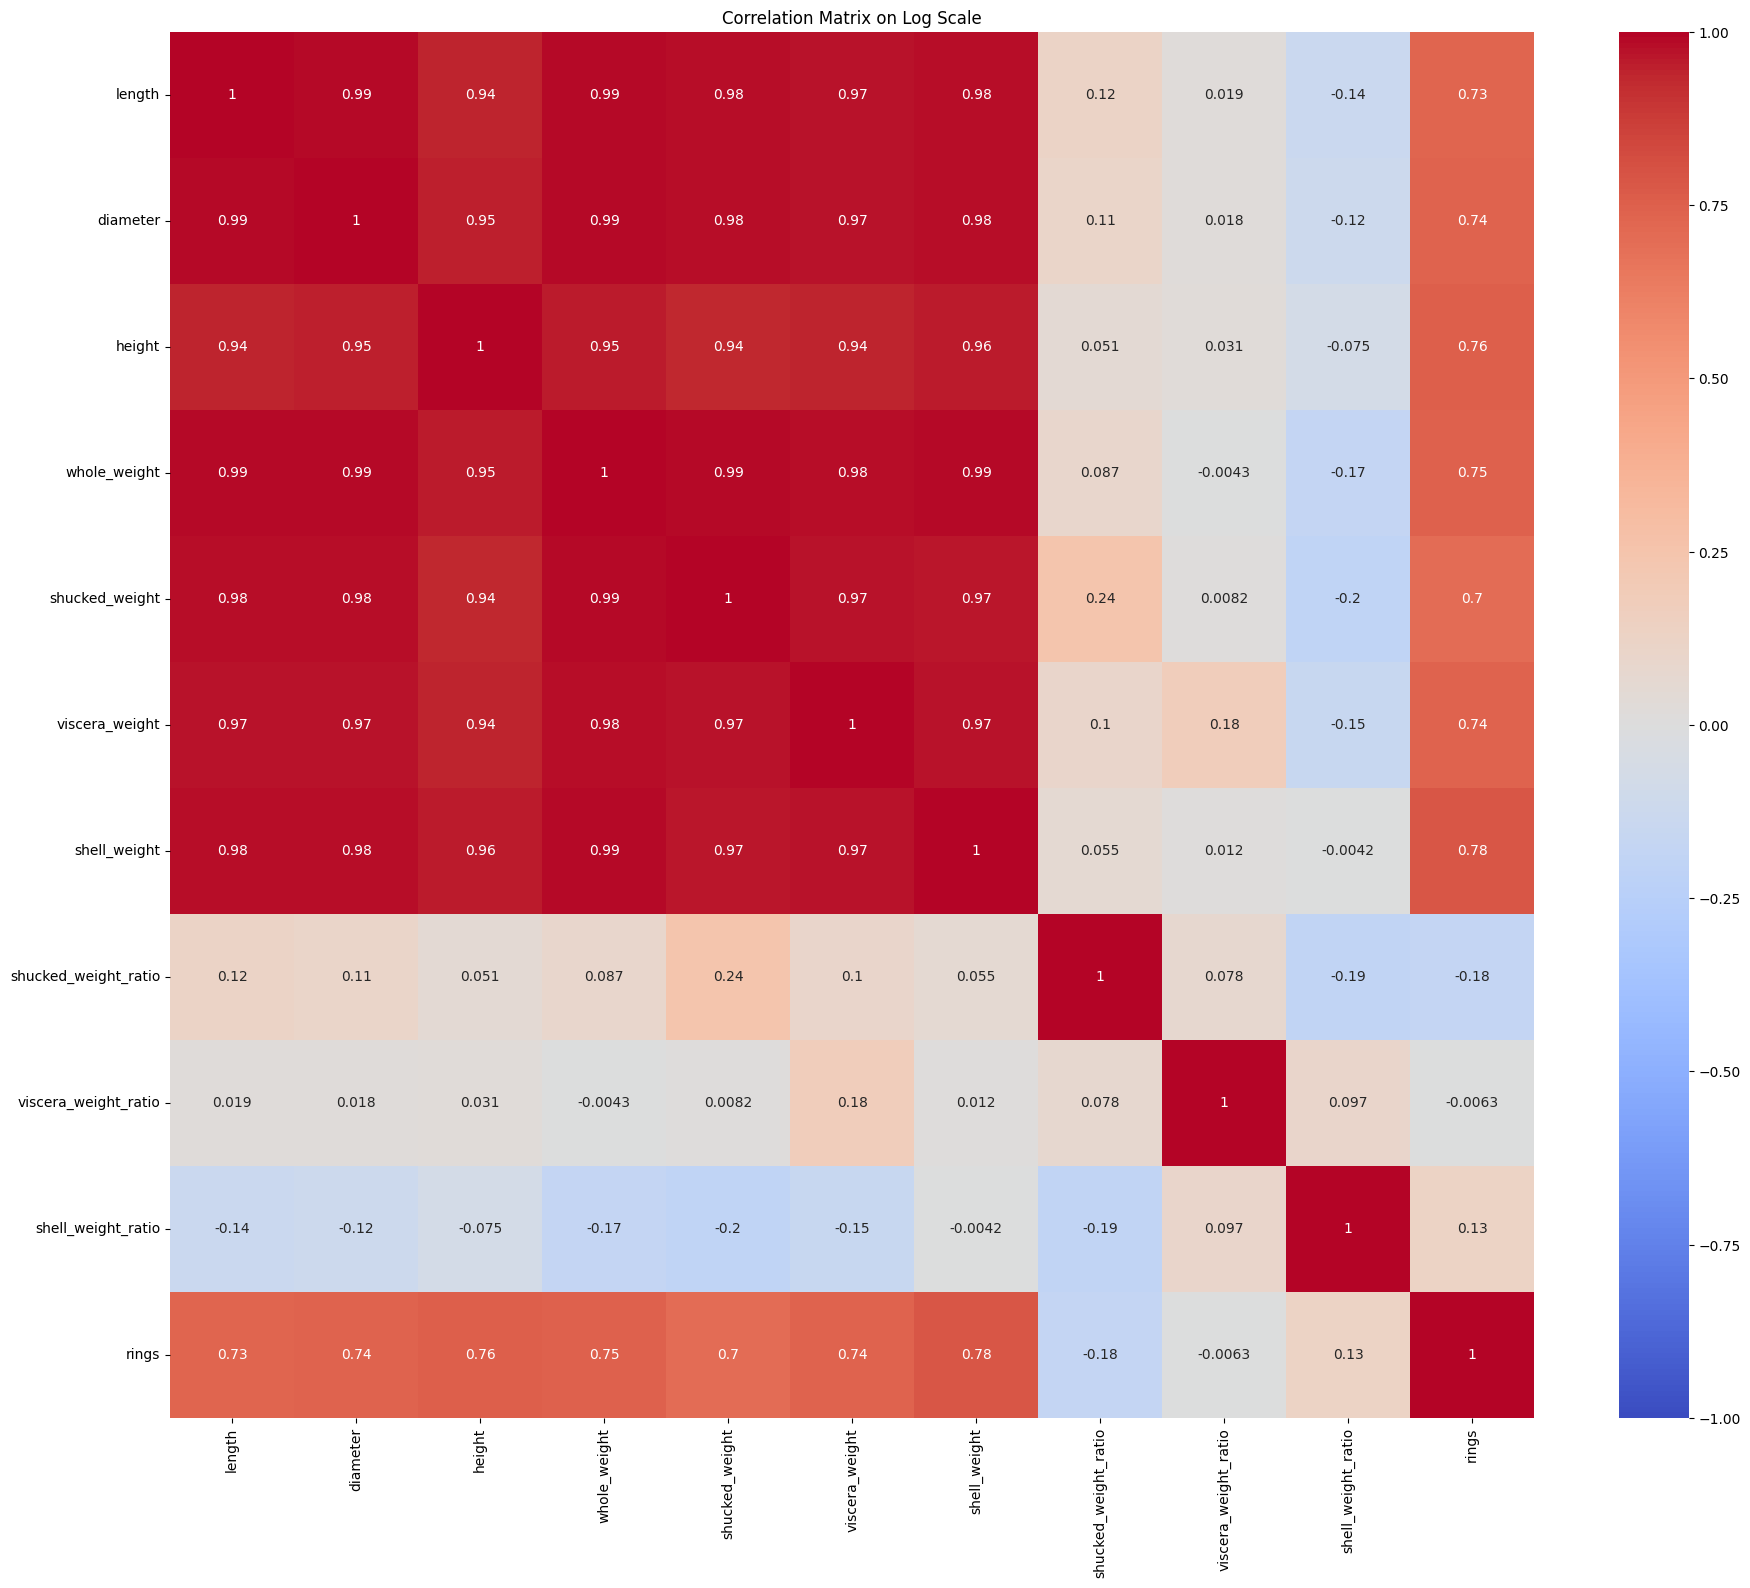

/opt/conda/lib/python3.10/site-packages/numpy/core/function_base.py:158: RuntimeWarning: invalid value encountered in multiply
  y *= step
/opt/conda/lib/python3.10/site-packages/numpy/core/function_base.py:168: RuntimeWarning: invalid value encountered in add
  y += start
/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


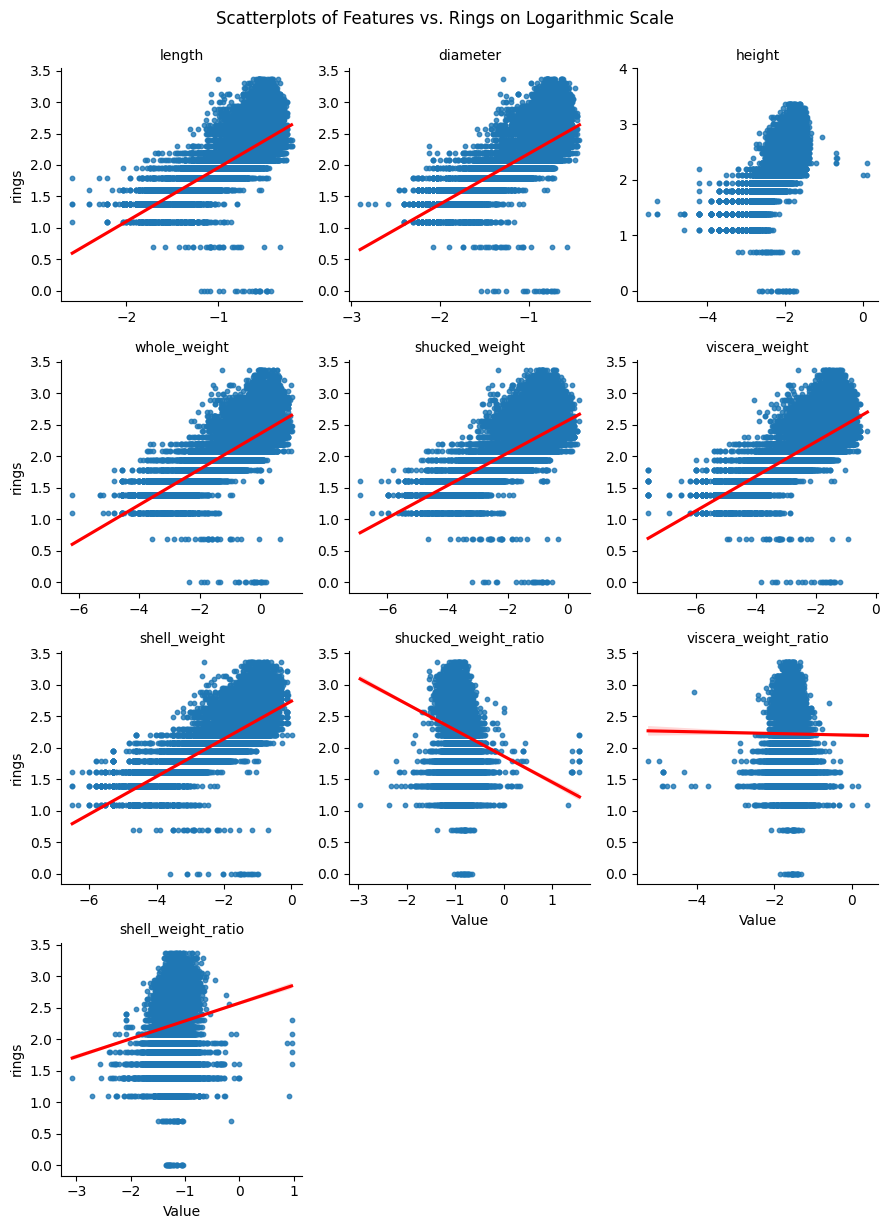

In [6]:
# Create a copy DataFrame with log scale
td_log = td.copy()
td_log[continuous] = np.log(td[continuous])

# Create new correlation matrix
corr_matrix_log = td_log[continuous].corr()

# Increase figure size to make the heatmap more readable
plt.figure(figsize=(22, 18))

# Plotting the matrix on logarithmic scale
sns.heatmap(corr_matrix_log, vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix on Log Scale')
plt.show()

# Plot scatterplots of all continuous features on log scale vs. sex
td_melted_log = td_log.melt(id_vars=['rings'], value_vars = continuous, var_name = 'Feature', value_name = 'Value')
g = sns.FacetGrid(td_melted_log, col="Feature", col_wrap=3, height=3, sharex=False, sharey=False)
g = g.map(sns.regplot, 'Value', 'rings', scatter_kws={"s": 10}, line_kws={"color": "red"})
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Scatterplots of Features vs. Rings on Logarithmic Scale', y=1.02)
plt.show()

From the above output, the relationships are have a *slightly* stronger linear relationship when plotted on a logarithmic scale. When we get to the modeling phase later, we will compare using the logarithmic data with linear models and using the regular data with non-linear models. 

## Feature Analysis on a Square Root Scale

The original scatterplots of the continuous features seemed to follow a square root curve pattern. To test this, let's scale our features by taking their square root, and then check our correlation matrix and linear regressions again:

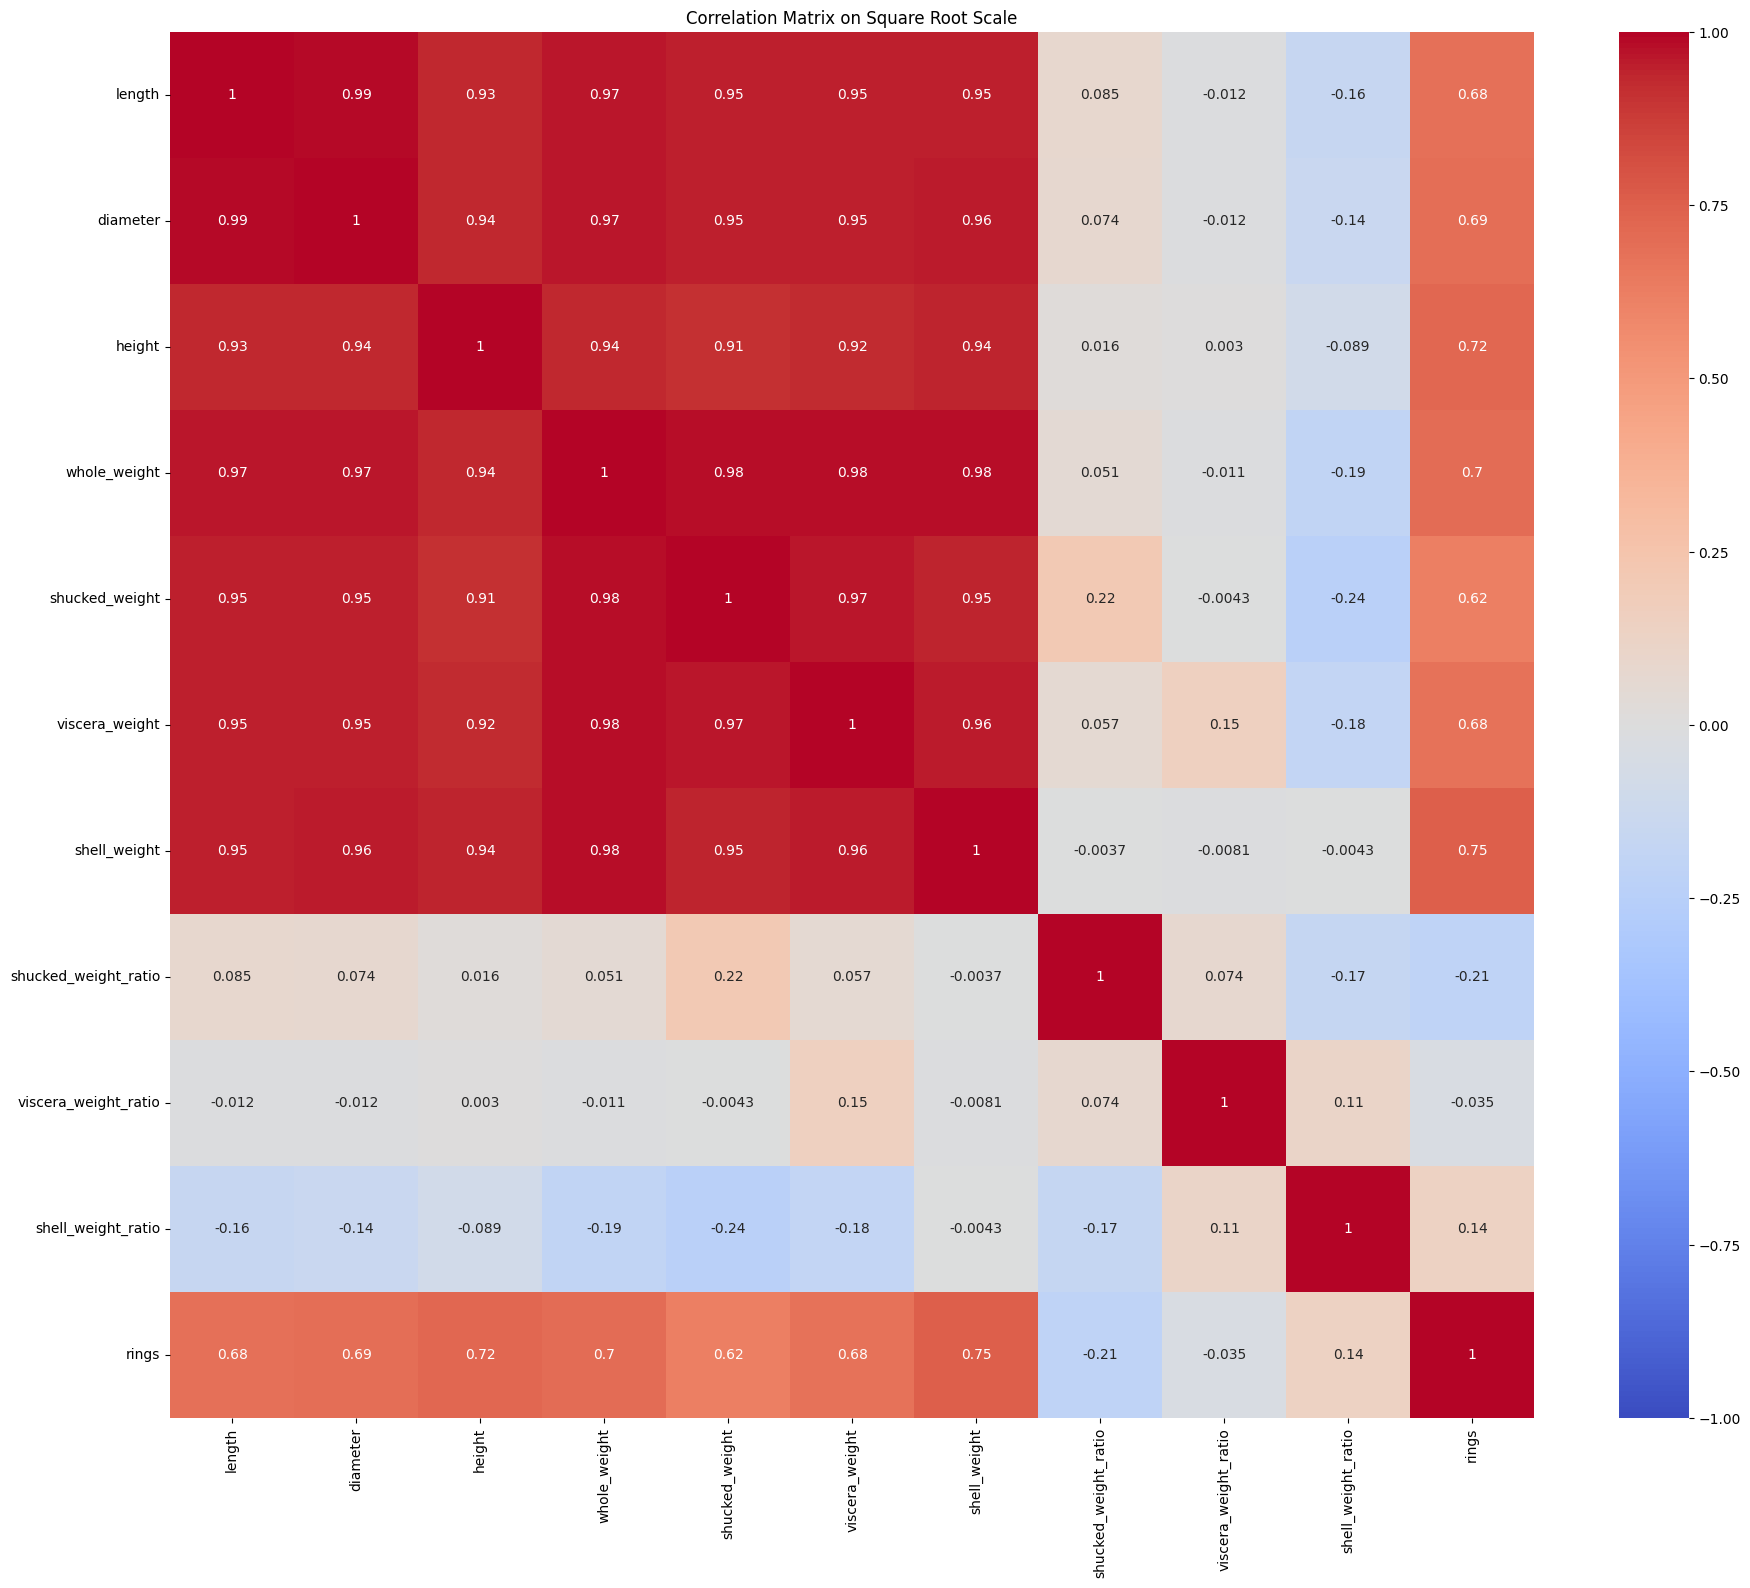

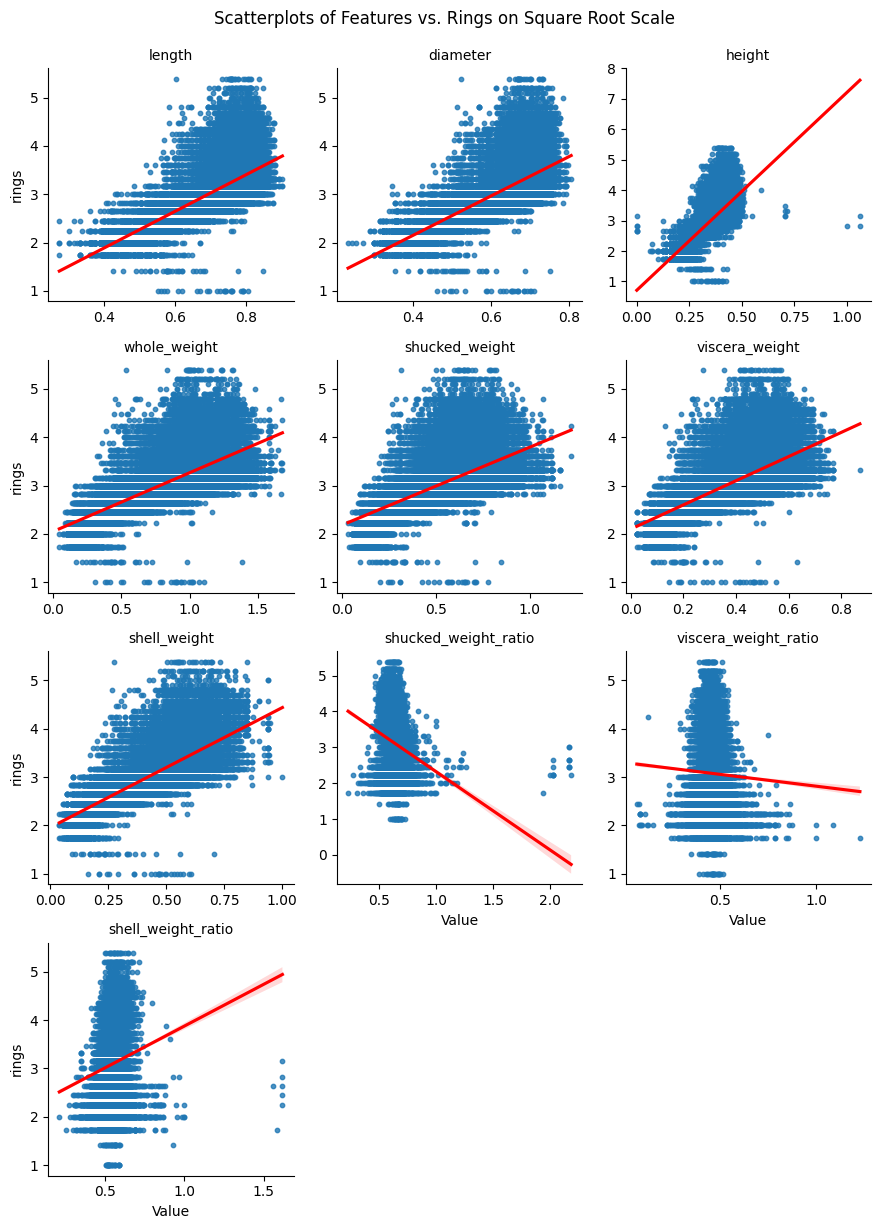

In [7]:
# Create a copy DataFrame with sqrt scale
td_sqrt = td.copy()
td_sqrt[continuous] = np.sqrt(td[continuous])

# Create new correlation matrix
corr_matrix_sqrt = td_sqrt[continuous].corr()

# Increase figure size to make the heatmap more readable
plt.figure(figsize=(22, 18))

# Plotting the matrix on logarithmic scale
sns.heatmap(corr_matrix_sqrt, vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix on Square Root Scale')
plt.show()

# Plot scatterplots of all continuous features on log scale vs. sex
td_melted_sqrt = td_sqrt.melt(id_vars=['rings'], value_vars = continuous, var_name = 'Feature', value_name = 'Value')
g = sns.FacetGrid(td_melted_sqrt, col="Feature", col_wrap=3, height=3, sharex=False, sharey=False)
g = g.map(sns.regplot, 'Value', 'rings', scatter_kws={"s": 10}, line_kws={"color": "red"})
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Scatterplots of Features vs. Rings on Square Root Scale', y=1.02)
plt.show()

From the above output, we can see that the features on a square root scale have a stronger correlation than the base features, but not as strong of correlations with the logarithmic features. We can safely assume that the square root scale won't be as useful as the logarithmic scale for predictions.

## Feature Analysis on Exponential Scale

Since the logarithmic scaling resulted in higher correlations, let's check an exponential scaling as well. Here is the same code block as before, but performing an exponential transformation on our continuous features:

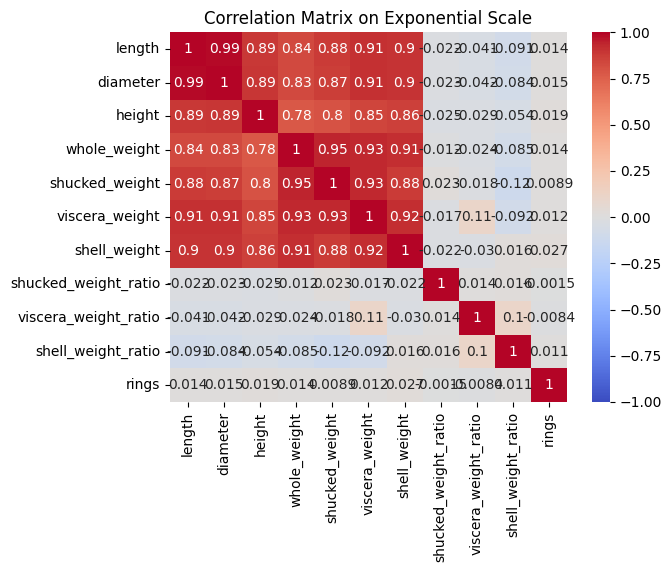

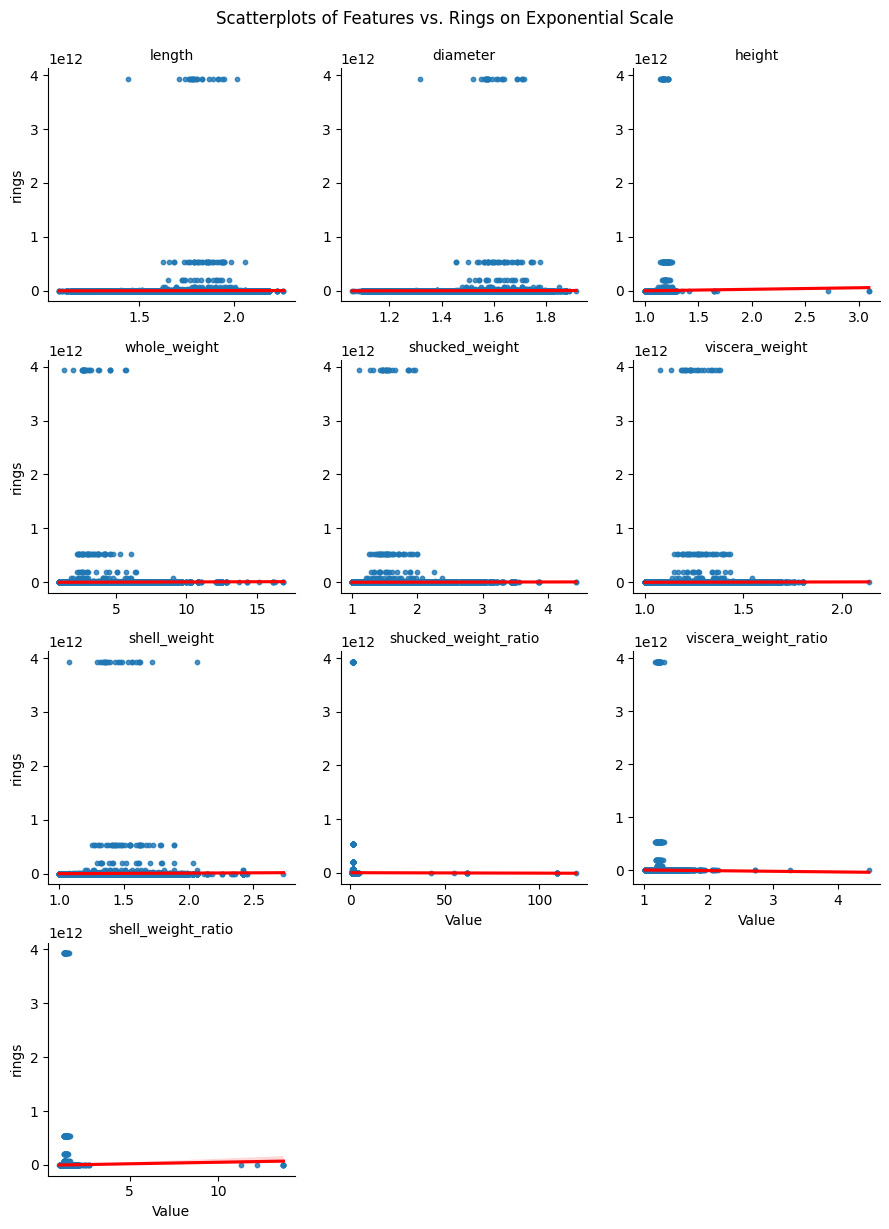

In [8]:
# Create a copy DataFrame with sqrt scale
td_exp = td.copy()
td_exp[continuous] = np.exp(td[continuous])

# Create new correlation matrix
corr_matrix_exp = td_exp[continuous].corr()

# Plotting the matrix on logarithmic scale
sns.heatmap(corr_matrix_exp, vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix on Exponential Scale')
plt.show()

# Plot scatterplots of all continuous features on log scale vs. sex
td_melted_exp = td_exp.melt(id_vars=['rings'], value_vars = continuous, var_name = 'Feature', value_name = 'Value')
g = sns.FacetGrid(td_melted_exp, col="Feature", col_wrap=3, height=3, sharex=False, sharey=False)
g = g.map(sns.regplot, 'Value', 'rings', scatter_kws={"s": 10}, line_kws={"color": "red"})
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Scatterplots of Features vs. Rings on Exponential Scale', y=1.02)
plt.show()

As we can see from the above output, an exponential scaling does not help create a linear relationship at all, so we can safely ignore it. Lastly, let's create a grid of histograms for each feature, just so we can get a quick glance at their distributions:

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

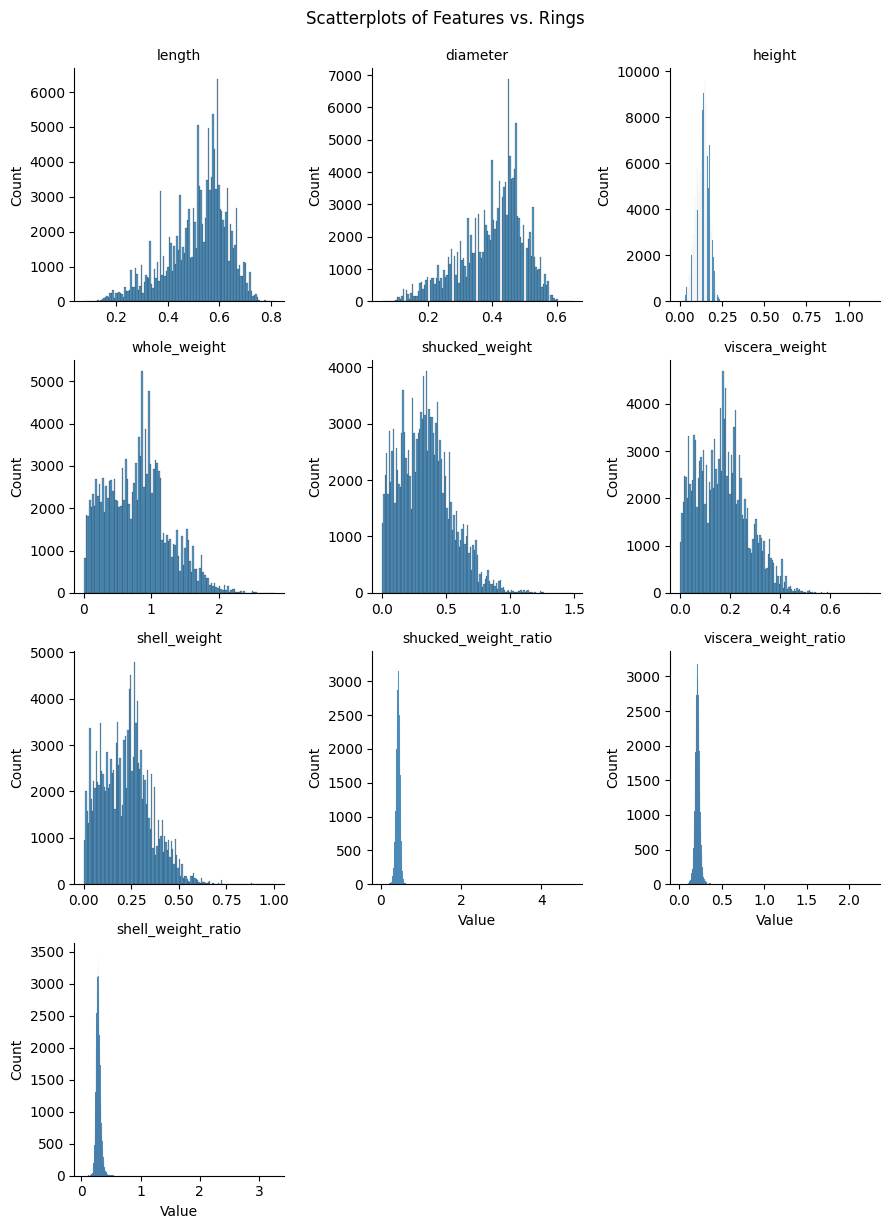

In [9]:
# Plot histograms of all continuous features
td_melted = td.melt(id_vars=['rings'], value_vars = continuous, var_name = 'Feature', value_name = 'Value')
g = sns.FacetGrid(td_melted, col="Feature", col_wrap=3, height=3, sharex=False, sharey=False)
g = g.map(sns.histplot, 'Value')
g.set_titles("{col_name}")
g.fig.tight_layout()
g.fig.suptitle('Scatterplots of Features vs. Rings', y=1.02)
plt.show()

One important thing to note about the above distributions: most of the features' distributions are not approximately normal. The ratio features may have an approximately normal distribution, but most of the other features have skewed distributions. When we preprocess our data later, we won't be able to use z-score standardization due to this.

## Continuous Features - Non-Linear Relationships

If we go back and look at our original scatterplots of our continuous features, each one demonstrates some non-linear relationship. Let's try to measure evidence of non-linear relationships using a couple different methods.

### Spearman's $\rho$ Correlation

Instead of using Pearson's correlation coefficient, let's calculate a correlation matrix using Spearman's correlation coefficient, which captures non-linear relationships more reliably:

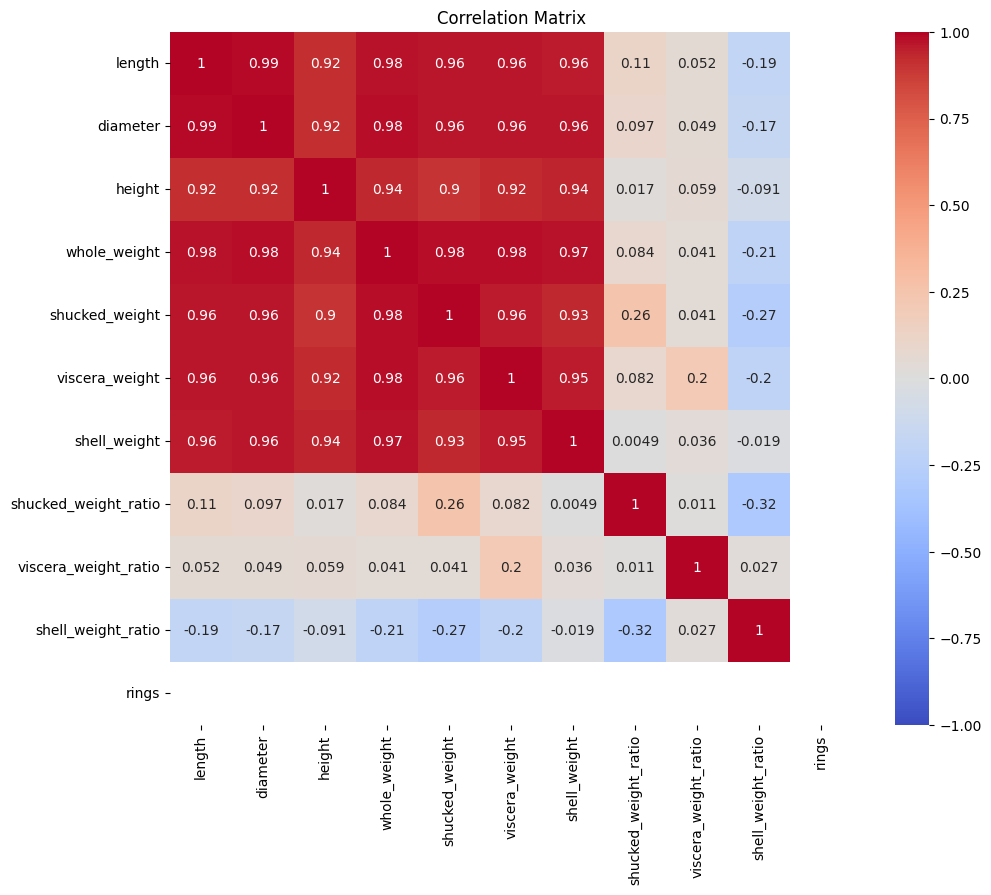

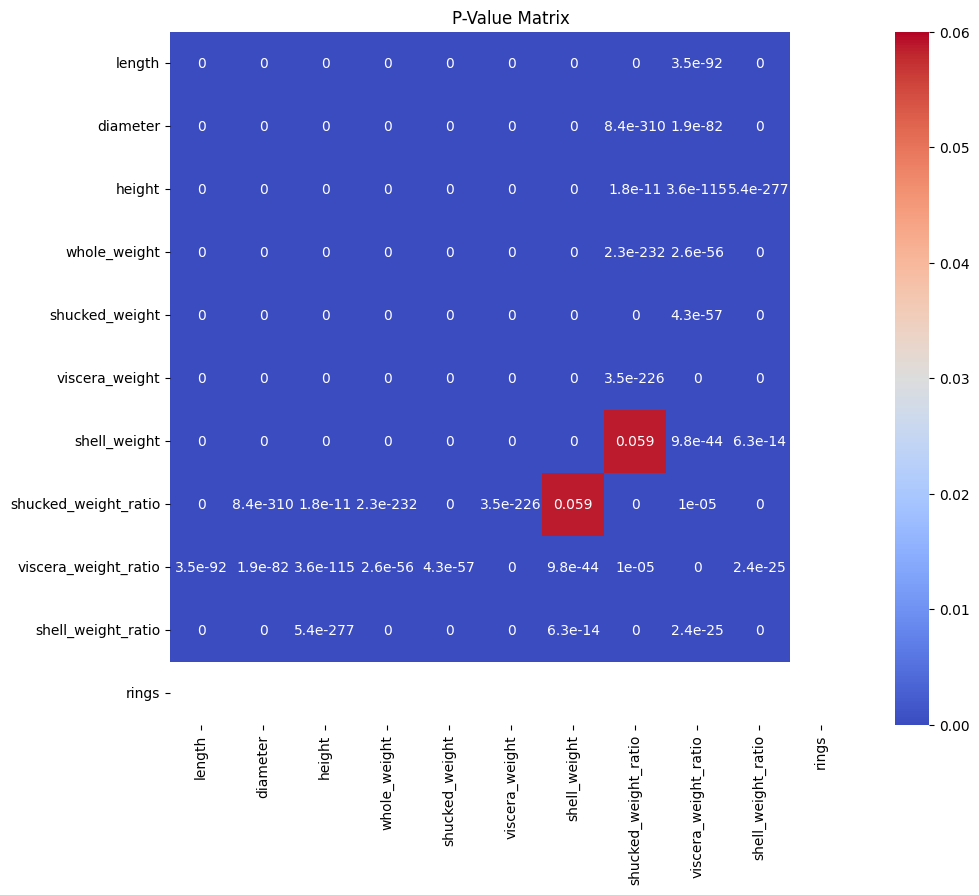

In [10]:
from scipy.stats import spearmanr

# Filter the DataFrame to include only the continuous columns
data_continuous = td[continuous]

# Calculate the Spearman's correlation matrix
correlation_matrix, p_value_matrix = spearmanr(data_continuous)

# Convert the correlation matrix to a DataFrame for better readability
spearman_corr_df = pd.DataFrame(correlation_matrix, index=continuous, columns=continuous)

# Optionally, convert the p-value matrix to a DataFrame
p_values_df = pd.DataFrame(p_value_matrix, index=continuous, columns=continuous)

# Display the correlation matrix
plt.figure(figsize=(11, 9))
sns.heatmap(spearman_corr_df, vmin = -1.0, vmax = 1.0, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Display the p-values matrix
plt.figure(figsize=(11, 9))
sns.heatmap(p_values_df, vmin = 0, vmax = 0.06, annot=True, cmap='coolwarm')
plt.title('P-Value Matrix')
plt.show()

The above matrices just reinforce our findings from earlier, that the ratio features do not have as strong as correlations as all of the base features. Let's look at one more measure of relationship:

### Mutual Information (MI)

For each combination of continuous feature, let's calculate their mutual information, or MI. The **mutual information** between two variables measures how much information one variable contains about another, which is a way of measuring how strong of a predictive relationship two variables have. This is calculated using each feature's **entropy**, which describes how predictable that feature is. We can use the scikit-learn library to calculate the mutual information for `rings` and each continuous feature:

In [11]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.utils import resample

# Check the mutual information for the training dataset
feat_continuous = continuous.copy()
feat_continuous.remove('rings')
X = train[feat_continuous]  # Feature set
y = train['rings']     # Target variable

# Calculate the mutual information
mi_scores = mutual_info_regression(X, y)

# Create a DataFrame for better visualization
mi_scores_df = pd.DataFrame(mi_scores, index=X.columns, columns=['MI Scores'])

# Sort the scores in descending order
mi_scores_df = mi_scores_df.sort_values(by='MI Scores', ascending=False)

# Display the mutual information scores
print(mi_scores_df)

                      MI Scores
shell_weight           0.678969
whole_weight           0.574954
height                 0.549005
viscera_weight         0.545595
diameter               0.542145
length                 0.530390
shucked_weight         0.511426
shucked_weight_ratio   0.233181
shell_weight_ratio     0.209270
viscera_weight_ratio   0.147998


The above output isn't *super* clear on how strong each feature's relationship to `rings` is, but it **does** give us a relative ranking of which features are more important. Now that we have an idea of what features are the most important, we can move onto the modeling phase.

# Modeling and Validation

## Preprocessing

Before we can get into choosing which models to try for our data, we must first preprocess our data. To avoid overfitting, we will choose four features: `sex` (due to its significance to `rings`), `shell_weight`, `whole_weight`, and `height` (due to their high MI scores). We will use `OneHotEncoder` to encode our categorical `sex` feature, and then use a Yeo-Johnson transformation to normalize our continuous features:

In [12]:
from sklearn.preprocessing import OneHotEncoder, PowerTransformer
from sklearn.compose import ColumnTransformer

# Create list of top features
features = ['sex', 'shell_weight', 'whole_weight', 'height']   # Top ranked features based on MI calculations
X = train[features]
y = train['rings']    # Prediction target

# Separate the features into categorical and continuous
categorical_features = ['sex']
continuous_features = ['shell_weight', 'whole_weight', 'height']

# Initialize the OneHotEncoder and PowerTransformer
encoder = OneHotEncoder(sparse_output=False)  # Set sparse_output to False to get a numpy array instead of sparse matrix
scaler = PowerTransformer(method='yeo-johnson')

# Create a ColumnTransformer for more efficient data pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', encoder, categorical_features),
        ('cont', scaler, continuous_features)
    ])

# Fit and transform the data
X_preprocessed = preprocessor.fit_transform(X)
y_preprocessed = scaler.fit_transform(np.array(y).reshape(-1, 1))

# Fix names for resulting dataframe
encoded_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
new_features = list(encoded_feature_names) + continuous_features

# Create the DataFrame showing the preprocessed data
X_preprocessed_df = pd.DataFrame(X_preprocessed, columns=new_features, index=train.index)

# Show the preprocessed DataFrame head to verify
print(X_preprocessed_df.head())

   sex_F  sex_I  sex_M  shell_weight  whole_weight    height
0    1.0    0.0    0.0      0.206233      0.064010  0.390682
1    1.0    0.0    0.0      0.781255      0.794640  0.259827
2    0.0    1.0    0.0     -1.967421     -1.967170 -2.982239
3    0.0    0.0    1.0      0.281837      0.368503  0.390682
4    0.0    1.0    0.0     -0.128110      0.087024 -0.134671


## Modeling and Validation

Now that our data is preprocessed, we can choose which models to try with our data. Due to its nonlinear nature, we will try the following algorithms:

1. **Random Forest Regressor**: Especially due to `sex`'s high significance, using a forest of decision trees could be a simple and robust algorithm for predicting `rings`. Additionally, it will require less hyperparameter tuning than other models.

2. **Multilayer Perceptron Regressor**: Due to the high amount of observations and the nonlinear nature of our features' relationships, a neural network may be better suited to discovering what relationships there are in the data.

In the below code blocks, we will train both models, and validate them both:

In [13]:
from sklearn.ensemble import RandomForestRegressor   
from sklearn.neural_network import MLPRegressor   # MultiLayer Perceptron Regressor
from sklearn.model_selection import cross_val_score, KFold    # K-fold Cross Validation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split    # Split training data
from sklearn.model_selection import GridSearchCV    # Hyperparameter tuning

# Split training data for model validation
X_train, X_test, y_train, y_test = train_test_split(X_preprocessed, y_preprocessed, test_size = 0.2)

# Flatten y_train for fitting
y_train = y_train.ravel()

In [14]:
# ---------- MODEL 1: RandomForestRegressor ----------
print("--------------------")
print("MODEL 1: Random Forest Regressor")
print("--------------------\n")

# ----- HYPERPARAMETER TUNING -----

# Initialize the K-folds for cross-validation
kfold = KFold(n_splits=3, shuffle=True, random_state=123)

""" HYPERPARAMETER TUNING IS COMMENTED OUT FOR COMPUTATIONAL EFFICIENCY

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [400, 450, 500],
    'max_depth': [10]
}

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=123), 
                           param_grid=param_grid, 
                           cv=kfold,  # you can reuse the kfold object from your code
                           scoring='neg_mean_squared_error', 
                           verbose=1, 
                           n_jobs=-1)  # Use all available cores

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation RMSE:", np.sqrt(-grid_search.best_score_))

# Use the best estimator to make predictions
rf_best = grid_search.best_estimator_
rf_y_pred = rf_best.predict(X_test)
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
print("Test RMSE with best Random Forest: ", rf_test_rmse)

"""

# ----- FITTING THE MODEL -----

# Initialize Random Forest with optimized parameters
rf = RandomForestRegressor(n_estimators = 300, max_depth = 10, random_state = 123)

# Calculate cross-validation scores
rforest_scores = cross_val_score(rf, X_train, y_train, cv = kfold, scoring = 'neg_mean_squared_error')
rforest_rmse_scores = np.sqrt(-rforest_scores)  # Calculate root mean squared error
print("RMSE per fold: ", rforest_rmse_scores)
print("Average RMSE: ", np.mean(rforest_rmse_scores))

# Fit the random forest model
rf.fit(X_train, y_train)
rf_y_pred = rf.predict(X_test)    # Make predictions
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_y_pred))
print("Test RMSE for Random Forest: ", rf_test_rmse)

--------------------
MODEL 1: Random Forest Regressor
--------------------

RMSE per fold:  [0.57832822 0.56370896 0.56947568]
Average RMSE:  0.5705042858239407
Test RMSE for Random Forest:  0.5732302550583246


Here is a log of all of the hyperparameter tuning that was done:

**Round 1** - Ran a grid search with possible n_estimators (100, 200, 300) and possible max_depths (None, 10, 20, 30). According to GridSearchCV, the best parameters were 300 estimators and a max_depth of 10.

**Round 2** - Ran a grid search with possible n_estimators (300, 350, 400) and possible max_depths (5, 10, 15). According to GridSearchCV, the best parameters were 400 estimators and a max_depth of 10.

**Round 3** - Since the n_estimators keeps increasing, we test (400, 450, 500) n_estimators with max_depth fixed at 10 based on the first two rounds of tuning. Our goal here is to see if the increase continues or if it plateaus at one point. According to GridSearchCV, the best parameters were 500 estimators and a max_depth of 10. **However**, the RMSE has seen little to no differences from 300 to 500 estimators. We will prioritize computational efficiency and use 500 estimators and a max depth of 10 for our model. 

In [15]:
# ---------- MODEL 2: Multilayer Perceptron Regressor ----------
print("\n--------------------")
print("MODEL 2: Multilayer Perceptron Regressor")
print("--------------------\n")

# Initialize MLP Regressor (hyperparameter tuning will come soon)
mlp = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='adam', max_iter=500, random_state=123)

# Calculate cross-validation scores
mlp_scores = cross_val_score(mlp, X_train, y_train, cv=kfold, scoring='neg_mean_squared_error')
mlp_rmse_scores = np.sqrt(-mlp_scores)
print("RMSE per fold: ", mlp_rmse_scores)
print("Average RMSE: ", np.mean(mlp_rmse_scores))

# Fit the MLP model
mlp.fit(X_train, y_train)
mlp_y_pred = mlp.predict(X_test)    # Make predictions on the test set

# Calculate RMSE for the MLP predictions
mlp_test_rmse = np.sqrt(mean_squared_error(y_test, mlp_y_pred))
print("Test RMSE for Multilayer Perceptron: ", mlp_test_rmse)


--------------------
MODEL 2: Multilayer Perceptron Regressor
--------------------

RMSE per fold:  [0.58314235 0.56990613 0.57641739]
Average RMSE:  0.5764886245540459
Test RMSE for Multilayer Perceptron:  0.5810130703639397


**NOTE:** This project is not yet finished, but below I will use my optimized Random Forest Regressor model to make my official predictions and submit them to Kaggle. I will return to this project to finish optimizing my MLP Regressor, but that will take a much longer time. I will remove this comment once I have finished optimizing both models.

Below, we can use our ______ model to predict the y-values in our test set, reverse the transformation of our y-values, and submit our predictions into an outside CSV file:

In [16]:
# Transform 'X' features in testing dataset
X_testing = test[features]
X_testing_preprocessed = preprocessor.transform(X_testing)

# Train optimized RForest Model on entire training data
rf_final = RandomForestRegressor(n_estimators = 300, max_depth = 10, random_state = 123)
rf_final.fit(X_preprocessed, y_preprocessed.ravel())
final_predictions = rf_final.predict(X_testing_preprocessed)
final_predictions_unscaled = scaler.inverse_transform(final_predictions.reshape(-1, 1))

# Create DataFrame of submissions and output to 'submissions.csv'
output = pd.DataFrame({'id': test['id'], 'Rings': final_predictions_unscaled.flatten()})
print(output)
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

           id      Rings
0       90615   9.749209
1       90616  10.617249
2       90617  10.216028
3       90618  10.547564
4       90619   7.608061
...       ...        ...
60406  151021   6.380381
60407  151022   9.386244
60408  151023   9.443576
60409  151024  11.899344
60410  151025   7.252007

[60411 rows x 2 columns]
Your submission was successfully saved!
